In [1]:
# Third-Party imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib widget
import ipywidgets as widgets
from ipywidgets import interactive, interact_manual, interact
import pyvista as pv
import itkwidgets
import pyansys

# Local imports
from util_loads import Propeller, Airfoil, Loadcase
from femodel import Threepartmodel as Propellermodel
from util_mapdl import Material

----
<img src="figures/lwx.png" alt="Logo LWX" title="" style="height:100px" align="right"/>
<img src="figures/logo_IFL.svg" alt="Logo IFL" title="" style="height:100px" align="left"/>

## Entwicklung eines automatisierten Auslegungs- und Optimierungsprogramms für anisotrope UAV-Propeller

## Kolloquium zur Masterarbeit

### Lukas Hilbers, 26. April 2021
### E-Mail: l.hi@posteo.de

<div style="text-align: right"> 1 / XX </div>

---
## Agenda
- ### Motivation und Methodik
- ### Vorstellung der Anwendung
- ### Implementierung eines Lastrechnungstools
- ### FE-Modellierung in Python
- ### Automatisierte Strukturoptimierung

<div style="text-align: right"> 2 / XX </div>

---
## Motivation und Methodik
<img src="figures/Helics_Mat_1.jpg" alt="Naturfasern" title="" style="height:400px" align="right"/>

- ### Studienarbeit: Evaluierung naturfaserverstärkter Kunststoffe für Einsatz in Multicopter-Propellern
    * ### FE-Simulationen mit generischem Modell mit ANSYS-APDL
    * ### Werkstoffe (insbes. FLAXPREG) prinzipiell geeignet
    * ### Offene Themen: Lastrechnung und Übertragung auf reale Geometrien
    * ### Workflow: Weitgehend händisch, umständlich
- ### Interessengebiete: Optimierung und Programmierung
- ### Idee: Entwicklung einer automatisierten Toolchain zur Auslegung in Python
    * ### PyMAPDL: interaktives Interface zwischen Python und Ansys
    * ### PyOpt: wissenschaftlich fundierte Optimierungs-Toolbox

<div style="text-align: right"> 3 / XX </div>

---
## Vorstellung der Anwendung

<img src="figures/Propeller.png" alt="MF3218-Propeller" title="" style="height:200px" align="right"/>

- ### 4-Motoriger Multicopter
    * ### MTOW 25kg (Obergrenze für zulassungsfreie Systeme)
- ### Ausgewählte Propellergeometrie: T-Motor MF3218
    * ### Durchmesser $\approx 813\,mm$
    * ### Maximale Drehzahl $4000\,\frac{1}{min}$
    * ### Maximaler Schub $18\,kg$ / $177\,N$

<div style="text-align: right"> 4 / XX </div>

---

## Implementierung eines Lastrechnungstools

<img src="figures/xfoil_logo.gif" alt="Naturfasern" title="" style="height:100px" align="right"/>

- ### Anforderungen:
    * ### Verwendung beliebiger Grundrisse und Profile
    * ### Auswertung verschiedener Lastfälle und Bildung einhüllender Lastverläufe
    * ### Integration in Python-Workflow
    
- ### Gewählter Ansatz:
    * ### Nutzung (semi-)analytischer Verfahren wie Traglinientheorie nach Prandtl <br> bzw. Propellertheorie nach Betz
    * ### Guter Kompromiss aus Genauigkeit und numerischem Aufwand
    * ### Löser wie XFOIL und XROTOR frei verfügbar 

<div style="text-align: right"> 5 / XX </div>

---

## Implementierung eines Lastrechnungstools: Architektur

<img src="figures/latex/uml_lastrechnung.png" alt="Naturfasern" title="" style="height:300px" align="right"/>

- ### Objektorientierter Ansatz
- ### Airfoil-Klasse:
    * ### Repräsentiert aerodynamische Profile des Propellers
    * ### Berechnung von Polaren, Druckverteilungen, Straakprofilen
    * ### Anbindung an XFOIL als Löser
- ### Loadcase-Klasse:
    * ### Modellierung von Lastfällen
    * ### Vorgabe von Anströmgschwindigkeit, Drehzahl, Leistung, Schub...
- ### Propeller-Klasse:
    * ### Repräsentiert gesamten Propeller
    * ### Berechnung von (einhüllenden) Lastverläufen
    * ### Ausgabe lokaler Strömungsparameter, Profile, <br> Schnittkräfte und -momente

<div style="text-align: right"> 6 / XX </div>

---

## Implementierung eines Lastrechnungstools: Anwendung

- ### Geometrie: MF3218
- ### Lastfall: Maximaler St

In [2]:
# Define Airfoil
airfoil = Airfoil('mf3218.xfo', 500000, iter_limit=600)
airfoil.set_polar(alpha_start=-20, alpha_stop=20, alpha_inc=0.25)

# Instantiate Propeller and assign geometry and airfoils
propeller = Propeller(number_of_blades=2,
                      tip_radius=0.412,
                      hub_radius=0.04,
                      )

#                              [r/R, c/R, beta]
propeller.geometry = np.array([[0.10,0.078,0],
                               [0.121, 0.078, 0.],
                               [0.155, 0.100, 5.99],
                               [0.223, 0.160, 17.97],
                               [0.345, 0.149, 14.44],
                               [0.417, 0.142, 12.68],
                               [0.490, 0.135, 11.18],
                               [0.563, 0.128, 9.94],
                               [0.636, 0.121, 8.97],
                               [0.709, 0.114, 8.26],
                               [0.782, 0.107, 7.81],
                               [0.854, 0.100, 7.63],
                               [0.947, 0.091, 7.5],
                               [1., 0.066, 7.5],                               
                               ])

propeller.sections = [[0.121, airfoil],
                      [1., airfoil],]

# Instantiate Loadcases
loadcase = Loadcase(name='Max RPM', flight_speed=0.01)

# Assign Loadcase to Propeller Object
propeller.add_loadcase(loadcase)
propeller.loadcases[0][0].set_data('rpm',4000)

# Calculate loads
propeller.calc_loads()
propeller.set_load_envelope()

In [3]:
X, Y, Cp_suc, Cp_pres = propeller.pressure_distribution('envelope')

fig = plt.figure(figsize=(10, 10))
ax = plt.axes(projection='3d')

ax.plot_surface(X, Y, -Cp_suc + Cp_pres,cmap='viridis', edgecolor='none')

ax.set_xlabel('rel. Radius y/R / 1')
ax.set_ylabel('rel. Profiltiefe x/C / 1')
ax.set_zlabel('Druckbeiwert -C_p / 1')

Unconverged point: Airfoil mf3218.xfo cl 0.873. Filling with 0.
Unconverged point: Airfoil mf3218.xfo cl 0.873. Filling with 0.


Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

Text(0.5, 0, 'Druckbeiwert -C_p / 1')

<div style="text-align: right"> 7 / XX </div>

---
## FE-Modellierung in Python

<img src="figures/latex/uml_analysemodell.png" alt="Analysemodell" title="" style="height:350px" align="right"/>

- ### PyMAPDL: Interaktives Python-ANSYS-Interface
- ### Objektorientierter Ansatz
    * ### Anbindung an Material-DB
    * ### Anbindung an Propeller-Klasse des Lasten-Tools


<div style="text-align: right"> 8 / XX </div>

---

In [4]:
# Set directory and jobname
ansys_path = '/home/y0065120/Dokumente/Leichtwerk/Projects/ansys-0/'
jobname ='job-0'

# Launch MAPDL
mapdl = pyansys.launch_mapdl(run_location=ansys_path,
                             nproc=2,
                             override=True,
                             loglevel='error',
                             additional_switches='-smp -d X11C',
                             jobname=jobname,
                             allow_ignore=True,
                             mode='console',
                            )

# Instantiate FE-Model
femodel = Propellermodel(mapdl,
                         mesh_density_factor=1,
                         propeller=[],
                         n_sec=20,
                        )

# Load Materials
femodel.materials = {'flaxpreg': Material(mapdl, 'FLAXPREG-T-UD', 1),
                     'balsa': Material(mapdl, 'balsaholz', 2),
                    }

# Load previous Pre-Processing
femodel.element_data = pd.read_csv('./mf3218/element_data.csv', index_col=(0))
femodel.cdread()

<div style="text-align: right"> 9 / XX </div>

---

## FE-Modellierung in Python: Modellaufbau

- ### Abstrahierung als 2D-Platte nach Kirchhoff'scher Plattentheorie
    * ### Shell-Element SHELL281
    * ### Einsparung Rechenaufwand $\rightarrow$ Optimierung

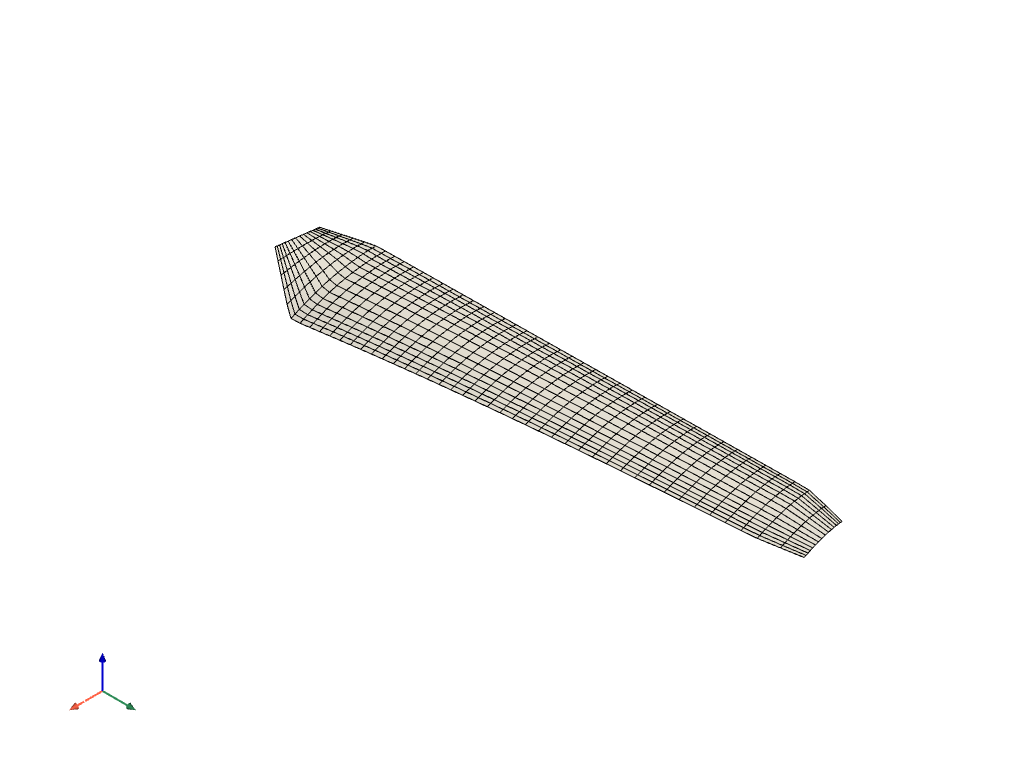

[(428.38723433846314, 641.3177829466106, 402.5458392165513),
 (18.0694474018525, 230.99999600999996, -7.771947720059352),
 (0.0, 0.0, 1.0)]

In [5]:
mapdl.eplot(background='w')

<div style="text-align: right"> 10 / XX </div>

---

## FE-Modellierung in Python: Lagenaufbau und Variablen

<img src="figures/latex/designvars.png" alt="Design-Variablen" title="" style="height:350px" align="right"/>

- ### Modellierung über Ersatz-Lagenpakete anstatt diskreter Lagen
- ### Radiale Unterteilung des Blattes in 20 Komponenten: $\text{j}=1,\,\dots,\,20$
- ### Variablen je Komponente $\text{j}$:
    * ### Fasermenge $\text{rho_j}$
    * ### Asymmetrie-Faktor $\text{div_j}$
- ### Variablen Global:
    * ### Orientierung Verbundwerkstoff $\text{phi_0}$
    * ### Orientierung Stützstoff $\text{phi_1}$


<div style="text-align: right"> 11 / XX </div>

---

## FE-Modellierung in Python: Lasten

- ### Zentrifugale Kräfte: Zuweisung als Rotation um Koordinatenursprung in ANSYS-APDL
- ### Luftkräfte: Anbindung an Lastrechnungstool

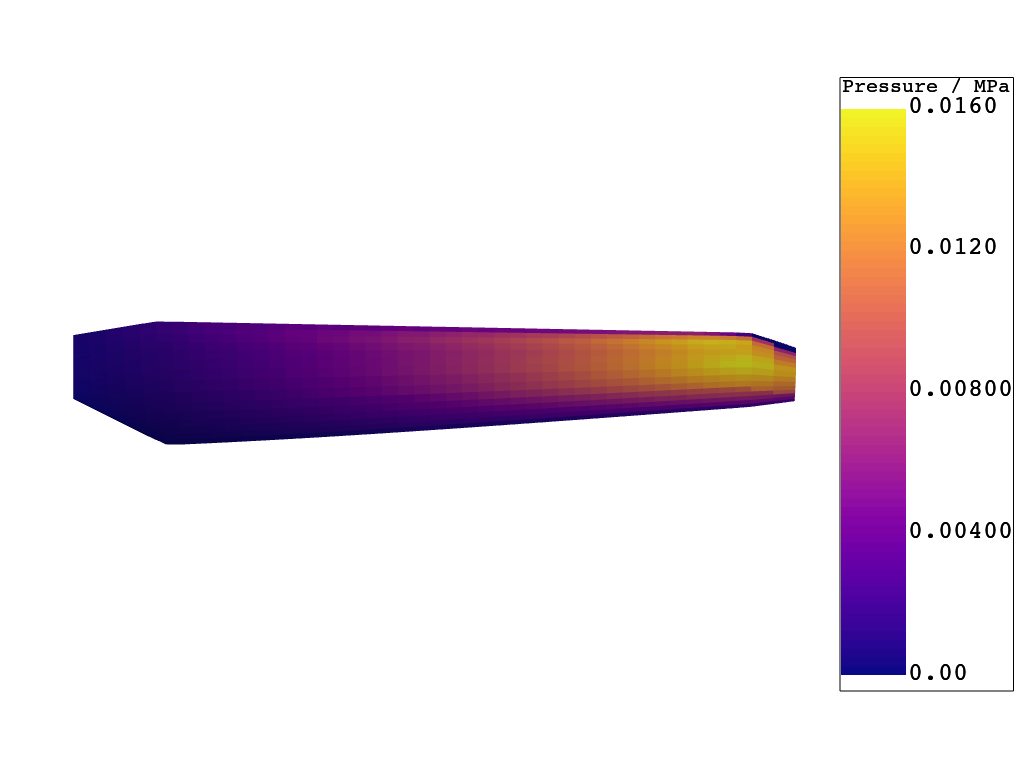

[(18.132821046913, 270.0, 718.5432175064541),
 (18.132821046913, 270.0, -7.771409650888949),
 (-1.0, 0.0, 0.0)]

In [67]:
pressure_lift = np.array(femodel.element_data['Pressure by Lift'])   
mesh = pv.read('femesh.vtk')

etb_scalar = []
for elem in mapdl.result.grid['ansys_elem_num']:
    etb_scalar.append(pressure_lift[elem-1])
etb_scalar = np.array(etb_scalar)

plotter = pv.Plotter(notebook=True)

plotter.add_mesh(mesh,
                 scalars=etb_scalar,
                 cmap='plasma',
                 clim=[0, 0.016],
                 show_scalar_bar=True,
                )
plotter.add_scalar_bar(title='Pressure / MPa',
                       color='black',
                       outline=True,
                      )
plotter.set_background('w')

cpos = [(18.132821046913, 270, 718.5432175064541),
        (18.132821046913, 270, -7.771409650888949),
        (-1.0, 0.0, 0.0)]
plotter.show(cpos=cpos)

<div style="text-align: right"> 12 / XX </div>

---

## Strukturoptimierung in Python

<img src="https://upload.wikimedia.org/wikipedia/commons/e/ec/ParticleSwarmArrowsAnimation.gif" alt="util_loads" title="" align="right"/>

- ### PyOpt: Modulare Optimierungstoolbox
    * ### Teilchenschwärme: ALPSO
    * ### Evolutionsstrategien: NSGA2
    * ### Gradientenbasierte Verfahren: SLSQP
    * ### ...
- ### Auswahl: Teilchenschwärme - ALSPO
    * ### Globale Suchmethode, keine Gradienten
    * ### Restriktionen und diskrete Variablen unterstützt
    * ### Parallelisierung möglich
- ### Idee Partikelschwarmverfahren:
    * ### Nachbildung des Verhaltens von Schwärmen im Tierreich
    * ### Beispiel: Vögelschwärme auf Suche nach Futterplätzen: <br> Vorteil durch geteiltes Wissen überwiegt Wettbewerb

<div style="text-align: right"> 13 / XX </div>

---

## Strukturoptimierung in Python: Optimierungsproblem

### Design-Variablen:
### $$\vec{x} = \left( \text{phi_0},\,
	\text{phi_1},\,
	\text{rho_0},\,
	\text{div_0},\,
	\dots,\,
	\text{rho_19},\,
	\text{div_19} \right) $$

### Minimiere
### $$\text{min}\, f(\vec{x}) = \sum_{j=0}^{19} \text{rho_j}$$

### sodass Puck'sche Versagenskriterien eingehalten werden
### $$g_{\text{fib, }j}(\vec{x}) =\,I_{\text{fib, }j}(\vec{x}) \,\,- 1 \le\,0; \quad j\,=0,\,\dots,\,19 \\ g_{\text{mat, }j}(\vec{x}) =\,I_{\text{mat, }j}(\vec{x}) \,\,- 1 \le\,0; \quad j\,=0,\,\dots,\,19$$

<div style="text-align: right"> 14 / XX </div>

---